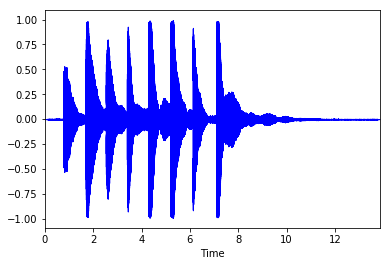

In [14]:
# 参考サイト：https://qiita.com/martin-d28jp-love/items/34161f2facb80edd999f

%matplotlib inline
import matplotlib.pyplot as plt, librosa, librosa.display, urllib
import numpy as np
import wave
import os

# spectral.py
def melspectrogram(y=None, sr=22050, S=None, n_fft=2048, hop_length=512,
                   power=2.0, **kwargs):
    '''
    y : np.ndarray [shape=(n,)] or None
        audio time-series

    sr : number > 0 [scalar]
        sampling rate of `y`

    S : np.ndarray [shape=(d, t)]
        spectrogram

    n_fft : int > 0 [scalar]
        length of the FFT window

    hop_length : int > 0 [scalar]
        number of samples between successive frames.
        See `librosa.core.stft`

    power : float > 0 [scalar]
        Exponent for the magnitude melspectrogram.
        e.g., 1 for energy, 2 for power, etc.
    '''
    S, n_fft = _spectrogram(y=y, S=S, n_fft=n_fft, hop_length=hop_length,
                            power=power)

    # Build a Mel filter
    mel_basis = filters.mel(sr, n_fft, **kwargs)

    return np.dot(mel_basis, S)

def _spectrogram(y=None, S=None, n_fft=1024, hop_length=512, power=1):

    if S is not None:
        # Infer n_fft from spectrogram shape
        n_fft = 2 * (S.shape[0] - 1)
    else:
        # Otherwise, compute a magnitude spectrogram from input
        S = np.abs(stft(y, n_fft=n_fft, hop_length=hop_length))**power

    return S, n_fft


################


file_path = "./music/doremi.wav"
x, fs = librosa.load(file_path, sr=44100)
wf = wave.open(file_path, "r")
file_name = os.path.splitext(file_path)[0]
librosa.display.waveplot(x, sr=fs, color='blue')

In [15]:
print(
"file_path:", file_path,
"\nmfcc shape:", librosa.feature.mfcc(x, sr=fs, n_mfcc = 128).shape,
"\nサンプリング周波数:", wf.getframerate(),
"\nx(audio time series):", x,
"\nx.shape:", x.shape,
"\nx type:", type(x),
"\nfs(sampling rate):", fs
)

file_path: ./music/doremi.wav 
mfcc shape: (128, 1193) 
サンプリング周波数: 48000 
x(audio time series): [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,  -4.10556027e-07
   2.04062957e-07   0.00000000e+00] 
x.shape: (610740,) 
x type: <class 'numpy.ndarray'> 
fs(sampling rate): 44100


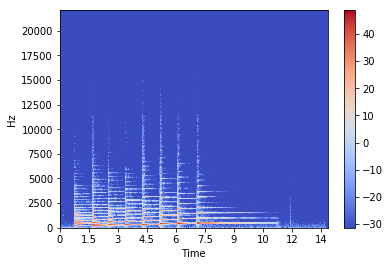

In [16]:
#1. 音声データを適当な長さのフレームに分割する
#2. Window関数を適応し、離散フーリエ変換して周波数スペクトルを得る
#   - STFT
#3. 対数をとる

stft = np.abs(librosa.stft(x, n_fft=1024, hop_length=512))**2
# window size : 1024 ms
# hop length : 512 ms
# - number audio of frames between STFT columns. If unspecified, defaults win_length / 4.
# win length : If unspecified, defaults to win_length = n_fft.
log_stft = librosa.power_to_db(stft)
# Take the logarithmof
# librosa.power_to_db
# - Convert a power spectrogram (amplitude squared) to decibel (dB) units.
#   This computes the scaling 10 * log10(S / ref) in a numerically stable way.

librosa.display.specshow(log_stft, sr=fs, x_axis='time', y_axis='hz')
plt.colorbar()

melsp: [[-1.4166986  -1.4166986  -1.4166986  ..., -1.22539647 -1.39213738
  -1.4166986 ]
 [-1.4166986  -1.4166986  -1.4166986  ..., -1.4166986  -1.4166986
  -1.4166986 ]
 [-1.4166986  -1.4166986  -1.4166986  ..., -1.4166986  -1.4166986
  -1.4166986 ]
 ..., 
 [-1.45676516 -1.45676516 -1.45676516 ..., -1.45676516 -1.45676516
  -1.45676516]
 [-1.45619019 -1.45619019 -1.45619019 ..., -1.45619019 -1.45619019
  -1.45619019]
 [-1.45543849 -1.45543849 -1.45543849 ..., -1.45543849 -1.45543849
  -1.45543849]] 
melsp shape: (128, 1193) 
bin power: [[-31.36166382 -31.36166382 -31.36166382 ..., -19.60672951 -24.91588974
  -31.36166382]
 [-31.36166382 -31.36166382 -31.36166382 ..., -25.45102119 -30.60279846
  -31.36166382]
 [-31.36166382 -31.36166382 -31.36166382 ..., -31.36166382 -31.36166382
  -31.36166382]
 ..., 
 [-31.36166382 -31.36166382 -31.36166382 ..., -31.36166382 -31.36166382
  -31.36166382]
 [-31.36166382 -31.36166382 -31.36166382 ..., -31.36166382 -31.36166382
  -31.36166382]
 [-31.3616

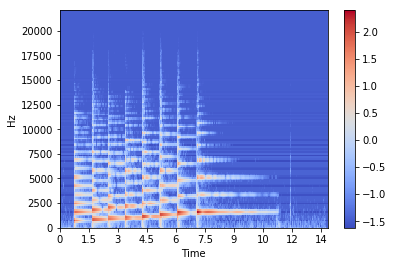

In [17]:
# 4. メル周波数で均等になるようBINを集めてスムージングする
#   - binパワー計算済みのSを利用して、メルフィルタバンクをあてる
melsp = librosa.feature.melspectrogram(S=log_stft)
librosa.display.specshow(melsp, sr=fs, x_axis='time', y_axis="hz")
plt.colorbar()
print("melsp:", melsp,
"\nmelsp shape:", melsp.shape,
"\nbin power:", log_stft)

In [18]:
# 5. 離散コサイン変換する（低次項を取る）
# デフォルト n_mfcc = 20bin
mfccs = librosa.feature.mfcc(S=melsp, n_mfcc=128)
print("mfccs shape", mfccs.shape)

mfccs shape (128, 1193)


mfccs: [[-1.12205698 -1.12205698 -1.12205698 ..., -1.11633438 -1.12132226
  -1.12205698]
 [-1.3610041  -1.3610041  -1.3610041  ..., -1.3511107  -1.35973389
  -1.3610041 ]
 [-1.74142903 -1.74142903 -1.74142903 ..., -1.70439598 -1.73667437
  -1.74142903]
 ..., 
 [-0.16954161 -0.16954161 -0.16954161 ..., -0.15143139 -0.16721645
  -0.16954161]
 [-0.17439931 -0.17439931 -0.17439931 ..., -0.16386313 -0.17304658
  -0.17439931]
 [ 0.04126695  0.04126695  0.04126695 ...,  0.04555553  0.04181756
   0.04126695]] 
mfccs type: <class 'numpy.ndarray'> 
mfccs shape: (128, 1193)


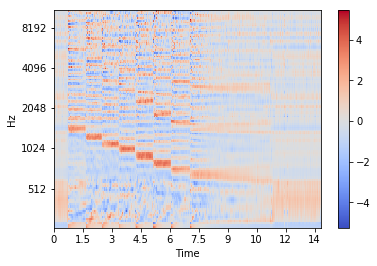

In [19]:
# 標準化して可視化
import sklearn
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
librosa.display.specshow(mfccs, sr=fs, x_axis='time', y_axis="mel")
plt.colorbar()
print(
"mfccs:", mfccs,
"\nmfccs type:", type(mfccs),
"\nmfccs shape:", mfccs.shape
)